In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, List,Dict
import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = Path("data")

TRENDS_DATA = DATA_ROOT / "google_trends"
STOCKS_DATA = DATA_ROOT / "market"
PROCESSED_DATA = DATA_ROOT / "processed"

In [3]:
def safe_read_csv(file_path)->Optional[pd.DataFrame]:
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            # logging.warning(f"DataFrame from {file_path} is empty.")
            return None
        return df
    except Exception as e:
        # logging.warning(f"Error reading {file_path}: {e}")
        return None

In [4]:
stocks_dfs: Dict[str, pd.DataFrame] = {}
trends_dfs: Dict[str, pd.Series] = {}

for f in STOCKS_DATA.glob("*.csv"):
    df = safe_read_csv(f)
    if df is not None:
        try:
            df = df.rename(columns={'Price': 'Date'}).iloc[2:,:]
            stocks_dfs[f.stem] = df.set_index('Date')
        except Exception as e:
            print(f"Error processing {f.stem}: {e}")
            continue

for f in TRENDS_DATA.glob("*.csv"):
    df = safe_read_csv(f)
    if df is not None:
        df.set_index('date', inplace=True)
        trends_dfs[f.stem] = df.iloc[:, 0]


assert all(df is not None for df in stocks_dfs.values()), "Some stock DataFrames failed to load"
assert all(df is not None for df in trends_dfs.values()), "Some trends DataFrames failed to load"

num_stocks_files = len(list(STOCKS_DATA.glob("*.csv")))
num_trends_files = len(list(TRENDS_DATA.glob("*.csv")))

print(f"Loaded {len(stocks_dfs)}/{num_stocks_files} stock data files.")
print(f"Loaded {len(trends_dfs)}/{num_trends_files} trends data files.")

Error processing company_info: "None of ['Date'] are in the columns"
Loaded 102/103 stock data files.
Loaded 2497/3104 trends data files.


In [5]:
def parse_stock_field(df:pd.DataFrame, field:str,stock_name:str)->Optional[pd.Series]:
    # Check if the field exists in the DataFrame
    if field in df.columns:
        df_ = df[field]
        df_.index.name='date'
        df_.name = stock_name
        return df_
    else:
        return None

In [6]:
stocks_shapes = pd.Series({stock: df.shape[0] for stock, df in stocks_dfs.items()}).astype(int)
common_length = stocks_shapes.value_counts().index[0]

reg_stocks_dfs: Dict[str, pd.DataFrame] = {stock: df for stock, df in stocks_dfs.items() if abs(df.shape[0] - common_length) < 15}
# remove duplicates from list
reg_stocks_dfs = {stock: df[~df.index.duplicated(keep='first')] for stock, df in reg_stocks_dfs.items()}

volume_dfs: List[pd.Series] = []
price_dfs: List[pd.Series] = []

for stock, df in reg_stocks_dfs.items():
    volume_sr = parse_stock_field(df, 'Volume', stock)
    if volume_sr is not None:
        volume_dfs.append(volume_sr)

    price_sr = parse_stock_field(df, 'Close', stock)
    if price_sr is not None:
        price_dfs.append(price_sr)

In [7]:
trends_dfs_shapes = pd.Series({trend: df.shape for trend, df in trends_dfs.items()})
print(trends_dfs_shapes.value_counts())

price_dfs_shapes = pd.Series({s.name: s.shape for s in price_dfs})
print(price_dfs_shapes.value_counts())

volume_dfs_shapes = pd.Series({s.name: s.shape for s in volume_dfs})
print(volume_dfs_shapes.value_counts())

(261,)    2497
Name: count, dtype: int64
(1256,)    78
(1254,)    12
(1255,)     2
(1243,)     1
Name: count, dtype: int64
(1256,)    78
(1254,)    12
(1255,)     2
(1243,)     1
Name: count, dtype: int64


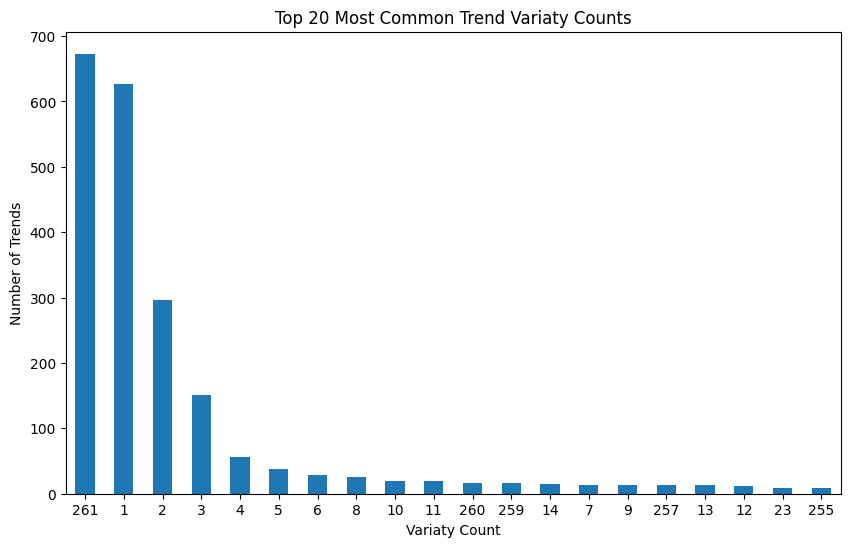

In [8]:
trends_variaty = pd.Series({s.name: len(np.nonzero(s)[0]) for trend, s in trends_dfs.items()})
trends_variaty.value_counts().head(10)

plt.figure(figsize=(10,6))
common_trends_variaty = trends_variaty.value_counts().head(20)
common_trends_variaty.plot(kind='bar')
plt.title('Top 20 Most Common Trend Variaty Counts')
plt.xlabel('Variaty Count')
plt.ylabel('Number of Trends')
plt.xticks(rotation=0)
plt.show()


In [9]:
interesting_trends_list: List[pd.Series] = []
for trend in trends_dfs.values():
    if len(np.nonzero(trend)[0])>2:
        interesting_trends_list.append(trend)

print(f'Found {len(interesting_trends_list)}/{len(trends_dfs)} interesting trends out of all trends.')

Found 1574/2497 interesting trends out of all trends.


In [10]:
volumes_raw = pd.concat(volume_dfs, axis=1).astype(float)
prices_raw = pd.concat(price_dfs, axis=1).astype(float)
trends_raw = pd.concat(interesting_trends_list, axis=1).astype(float)



prices_null_stocks = prices_raw.columns[prices_raw.isna().sum()>5]
volumes_null_stocks = volumes_raw.columns[volumes_raw.isna().sum()>5]
stocks_to_remove = prices_null_stocks.union(volumes_null_stocks)

trends_to_remove = trends_raw.columns[trends_raw.isna().sum()>5]

prices_clean = prices_raw.drop(columns=stocks_to_remove)
volumes_clean = volumes_raw.drop(columns=stocks_to_remove)
trends_clean = trends_raw.drop(columns=trends_to_remove)

In [11]:
def interpolate_values_by_date(df:pd.DataFrame)->pd.DataFrame:
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    df_daily = df.resample('D').asfreq()
    df_daily = df_daily.interpolate(method='linear')
    return df_daily

In [12]:

trends = interpolate_values_by_date(trends_clean)
prices = interpolate_values_by_date(prices_clean)
volumes = interpolate_values_by_date(volumes_clean)

index_intersection = trends.index.intersection(prices.index).intersection(volumes.index)
dates_price_null = prices_raw.index[prices_raw.isna().sum(axis=1)>0].union(prices.index[prices.isna().sum(axis=1)>0])
dates_volume_null = volumes_raw.index[volumes_raw.isna().sum(axis=1)>0].union(volumes.index[volumes.isna().sum(axis=1)>0])
dates_trends_null = trends_raw.index[trends_raw.isna().sum(axis=1)>0].union(trends.index[trends.isna().sum(axis=1)>0])
null_dates = dates_price_null.union(dates_volume_null).union(dates_trends_null).astype("datetime64[ns]")
valid_index = index_intersection[~index_intersection.isin(null_dates)]
print(f"Valid index length after removing null dates: {len(valid_index)}/{len(index_intersection)}")

trends=trends.loc[valid_index]
prices=prices.loc[valid_index]
volumes=volumes.loc[valid_index]

assert trends.index.equals(prices.index) and prices.index.equals(volumes.index), "Indexes do not match after alignment"
trends.shape, prices.shape, volumes.shape

Valid index length after removing null dates: 1781/1796


((1781, 1574), (1781, 92), (1781, 92))

In [15]:
trends.to_csv(PROCESSED_DATA / "trends.csv")
prices.to_csv(PROCESSED_DATA / "prices.csv")
volumes.to_csv(PROCESSED_DATA / "volumes.csv")